In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import joblib
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display
from ipywidgets import FileUpload


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
# Fungsi untuk memuat dataset dan menampilkan informasi kelas
def load_dataset_and_display_info(data_dir, classes, img_size=(224, 224)):
    images = []
    labels = []
    for class_index, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        class_images = os.listdir(class_dir)
        print(f"Class '{class_name}' has {len(class_images)} images.")

        # Tampilkan beberapa gambar contoh dari setiap kelas
        plt.figure(figsize=(15, 5))
        for i, img_name in enumerate(class_images[:5]):  # Tampilkan 5 gambar pertama dari setiap kelas
            img_path = os.path.join(class_dir, img_name)
            img = load_img(img_path, target_size=img_size)
            plt.subplot(1, 5, i + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')

        plt.show()

        for img_name in class_images:
            img_path = os.path.join(class_dir, img_name)
            img = load_img(img_path, target_size=img_size)
            img = img_to_array(img) / 255.0
            images.append(img)
            labels.append(class_index)
    return np.array(images), np.array(labels)



# Define paths
data_dir = 'D:\SEMESTER 7\BISMILLAH SKRIPSI\jagung-test\data'
classes = ['Gray_Leaf_Spot', 'Common_Rust', 'Blight', 'Healthy']


Class 'Gray_Leaf_Spot' has 574 images.


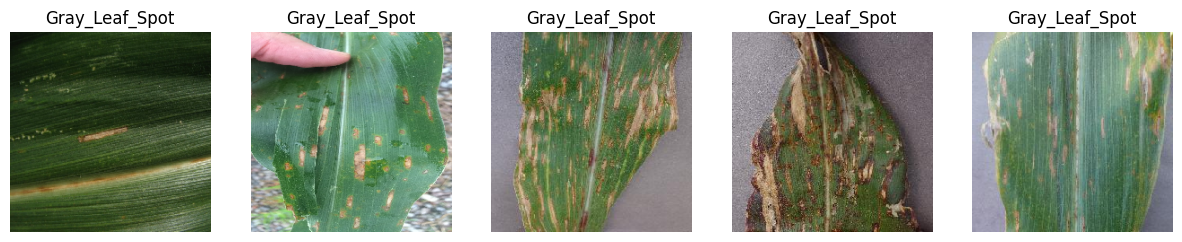

Class 'Common_Rust' has 1306 images.


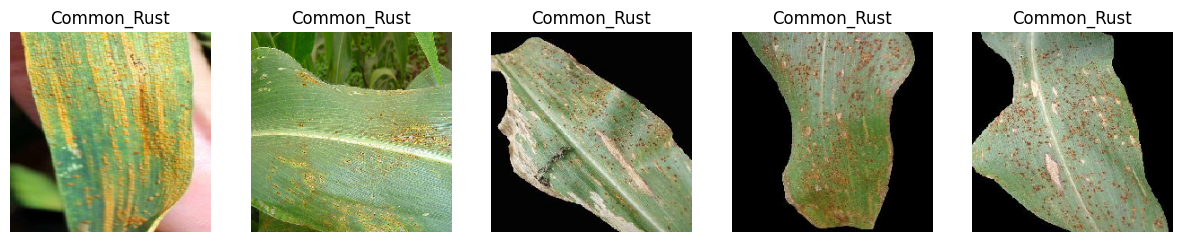

Class 'Blight' has 1147 images.


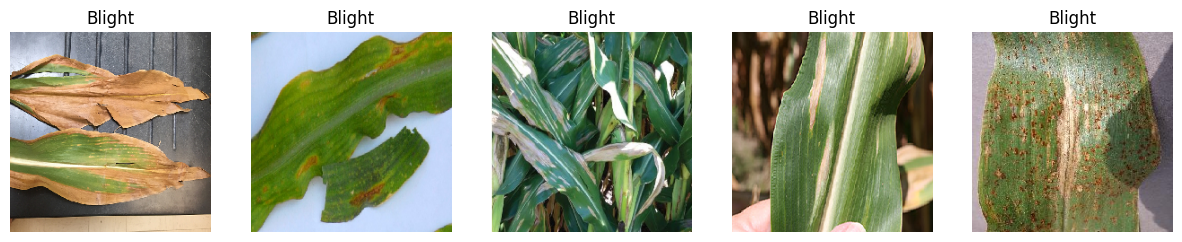

Class 'Healthy' has 1162 images.


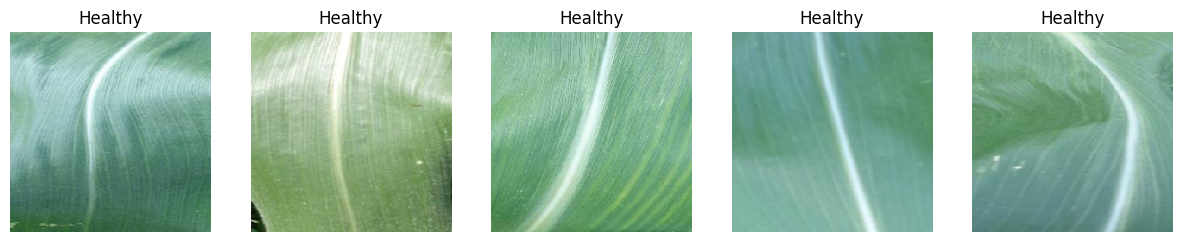

Jumlah data pelatihan: 2513
Jumlah data uji: 1676


In [5]:
# Muat dataset dan konversi label menjadi one-hot encoding
X, y = load_dataset_and_display_info(data_dir, classes)
y = to_categorical(y, num_classes=len(classes))

# Bagi dataset menjadi set pelatihan dan uji dengan perbandingan 60:40
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Tampilkan jumlah dataset yang displit
print(f"Jumlah data pelatihan: {len(X_train)}")
print(f"Jumlah data uji: {len(X_test)}")

# Data augmentation
datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)

# Buat data generators
train_generator = datagen.flow(X_train, y_train, batch_size=32)
test_generator = datagen.flow(X_test, y_test, batch_size=32, shuffle=False)


In [6]:
# Build ResNet model with Batch Normalization and Regularization
def build_resnet_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

In [7]:
# Build and compile models
input_shape = (224, 224, 3)
num_classes = len(classes)

# Define the path in Google Drive
model_save_path = 'D:\SEMESTER 7\BISMILLAH SKRIPSI\jagung-test\model_resnet.h5'
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

class StopTrainingAtAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, target_accuracy):
        super(StopTrainingAtAccuracy, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')
        if accuracy is not None and accuracy >= self.target_accuracy:
            print(f"\nTraining stopped as training accuracy reached {self.target_accuracy * 100:.2f}%")
            self.model.stop_training = True

# Inisialisasi callback
stop_training_callback = StopTrainingAtAccuracy(target_accuracy=0.95)

# Build model and compile model
resnet_model = build_resnet_model(input_shape, num_classes)

# ====================
# Adjust Learning Rate and Optimizer
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                     loss='categorical_crossentropy', metrics=['accuracy'])
# resnet_model.summary()

# ====================
# Callbacks
checkpoint_filepath = 'best_model.keras'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    # save_format='keras',
    save_freq='epoch'
)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

# Gabungkan semua callbacks
callbacks = [stop_training_callback, model_checkpoint, early_stopping, reduce_lr]

# Train ResNet50 model
history_resnet = resnet_model.fit(train_generator, epochs=10, validation_data=test_generator,
                                  callbacks=callbacks, verbose=1)


# Load best model using new format
resnet_model.load_weights('best_model.keras')
# joblib.dump(resnet_model, 'resnet_model.pkl')
# Save the model using joblib
resnet_model.save(model_save_path)


Epoch 1/10


d:\SEMESTER 7\BISMILLAH SKRIPSI\sistem\test-model\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 369s 5s/step - accuracy: 0.5902 - loss: 1.1990 - val_accuracy: 0.1426 - val_loss: 1.4759 - learning_rate: 1.0000e-04
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 394s 5s/step - accuracy: 0.7141 - loss: 0.7607 - val_accuracy: 0.3813 - val_loss: 1.3594 - learning_rate: 1.0000e-04
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 349s 4s/step - accuracy: 0.7344 - loss: 0.6980 - val_accuracy: 0.2792 - val_loss: 1.5143 - learning_rate: 1.0000e-04
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 362s 5s/step - accuracy: 0.7644 - loss: 0.6326 - val_accuracy: 0.2882 - val_loss: 2.0160 - learning_rate: 1.0000e-04
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 404s 5s/step - accuracy: 0.7913 - loss: 0.5883 - val_accuracy: 0.4839 - val_loss: 1.0883 - learning_rate: 1.0000e-04
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 385s 5s/step - accuracy: 0.7970 - loss: 0.5415 - val_accuracy: 0.5400 - val_loss: 1.1641 - learning_rate: 1.0000e-04
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 336s 4s/step - accuracy: 0.7993 - loss: 0.5

OSError: [Errno 22] Unable to synchronously create file (unable to open file: name = 'D:\SEMESTER 7\BISMILLAH SKRIPSI\jagung-testesnet_model.h5', errno = 22, error message = 'Invalid argument', flags = 13, o_flags = 302)

In [13]:
# Data generators
# train_generator_efficientnet = datagen.flow(X_train, y_train, batch_size=32)
# test_generator_efficientnet = datagen.flow(X_test, y_test, batch_size=32, shuffle=False)

def build_efficientnet_model(input_shape, num_classes):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

In [16]:
# Build and compile the model
input_shape = (224, 224, 3)
num_classes = len(classes)
efficientnet_model = build_efficientnet_model(input_shape, num_classes)

efficientnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                           loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint_filepath = 'best_model.keras'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

callbacks = [model_checkpoint, early_stopping, reduce_lr]

# Train the model
history_efficientnet = efficientnet_model.fit(train_generator, epochs=20, 
                                              validation_data=test_generator,
                                              callbacks=callbacks, verbose=1)

# Load the best model
efficientnet_model.load_weights(checkpoint_filepath)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 308s 4s/step - accuracy: 0.2625 - loss: 12.4850 - val_accuracy: 0.3115 - val_loss: 9.9457 - learning_rate: 0.0010
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 282s 4s/step - accuracy: 0.4641 - loss: 9.5770 - val_accuracy: 0.3115 - val_loss: 7.6841 - learning_rate: 0.0010
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 300s 4s/step - accuracy: 0.5296 - loss: 7.0789 - val_accuracy: 0.2774 - val_loss: 6.2615 - learning_rate: 0.0010
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 332s 4s/step - accuracy: 0.6038 - loss: 5.1711 - val_accuracy: 0.2774 - val_loss: 10.5747 - learning_rate: 0.0010
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 317s 4s/step - accuracy: 0.6032 - loss: 3.8020 - val_accuracy: 0.3115 - val_loss: 3.9388 - learning_rate: 0.0010
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 302s 4s/step - accuracy: 0.6276 - loss: 2.8849 - val_accuracy: 0.3115 - val_loss: 4.8812 - learning_rate: 0.0010
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 314s 4s/step - accuracy: 0.6628 - loss: 2.2608 - val_a

In [17]:
# import joblib
# model ResNet untuk membuat fitur masukan
resnet_features = resnet_model.predict(X_test)

# model EfficientNet untuk membuat fitur masukan
efficientnet_features = efficientnet_model.predict(X_test)

# Menggabungkan fitur masukan dari kedua model
ensemble_features = np.concatenate((resnet_features, efficientnet_features), axis=1)

# Definisikan dan latih model ensemble (misalnya, menggunakan RandomForest)
ensemble_model = RandomForestClassifier(n_estimators=100, random_state=42)
ensemble_model.fit(ensemble_features, y_test)

# Evaluasi model ensemble
ensemble_predictions = ensemble_model.predict(ensemble_features)
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Ensemble Model Accuracy:", ensemble_accuracy)

# Simpan model ensemble ke dalam file
# joblib.dump(ensemble_model, 'ensemble_model.pkl')



53/53 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step
Ensemble Model Accuracy: 1.0


In [19]:



# Split data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(ensemble_features, y_test, test_size=0.2, random_state=42)

# Train the ensemble model on the training data
ensemble_model = RandomForestClassifier(n_estimators=100, random_state=42)
ensemble_model.fit(X_train, y_train)

# Evaluate the model on the training data
train_predictions = ensemble_model.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)
print("Training Accuracy:", train_accuracy)

# Evaluate the model on the validation data
val_predictions = ensemble_model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print("Validation Accuracy:", val_accuracy)

# Perform k-fold cross-validation
k = 5  # Number of folds
cross_val_scores = cross_val_score(ensemble_model, ensemble_features, y_test, cv=k)
print(f"{k}-fold Cross-validation Accuracy: {cross_val_scores.mean()}")

# Check for overfitting or underfitting
if train_accuracy > val_accuracy:
    if train_accuracy - val_accuracy > 0.1:  # threshold to detect overfitting
        print("The model is likely overfitting.")
    else:
        print("The model is performing well.")
elif train_accuracy < val_accuracy:
    print("The model might be underfitting.")
else:
    print("The model is performing well on both training and validation data.")


Training Accuracy: 0.9992537313432835
Validation Accuracy: 0.8184523809523809
5-fold Cross-validation Accuracy: 0.8305330490405117
The model is likely overfitting.


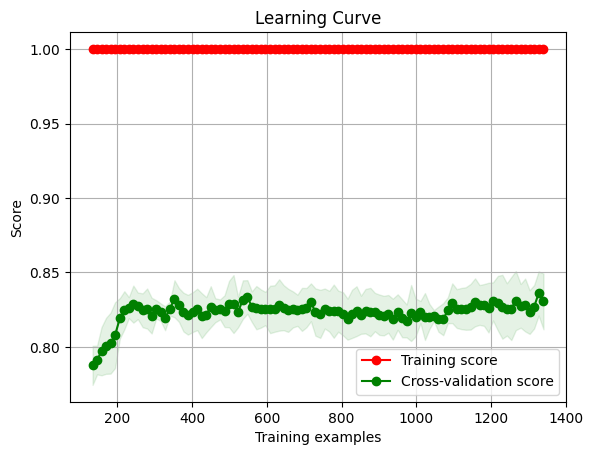

In [25]:


# Model yang digunakan
ensemble_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Membuat Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    ensemble_model, ensemble_features, y_test, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 100), random_state=42)

# Menghitung rata-rata dan deviasi standar dari akurasi pelatihan dan pengujian
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot Learning Curve
plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

# Plot area untuk deviasi standar
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color="g")

# Plot akurasi pelatihan dan pengujian
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()


In [22]:

# Bagi data menjadi set pelatihan dan set validasi
X_train, X_val, y_train, y_val = train_test_split(ensemble_features, y_test, test_size=0.2, random_state=42)

# Latih model pada set pelatihan
ensemble_model.fit(X_train, y_train)

# Evaluasi model pada set pelatihan
train_predictions = ensemble_model.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)
print("Train Accuracy:", train_accuracy)

# Evaluasi model pada set validasi
val_predictions = ensemble_model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print("Validation Accuracy:", val_accuracy)


Train Accuracy: 0.9992537313432835
Validation Accuracy: 0.8184523809523809


In [27]:


# Prediksi menggunakan model ensemble
ensemble_predictions = ensemble_model.predict(ensemble_features)

# Hitung metrik evaluasi
print("Classification Report:")
print(classification_report(y_test.argmax(axis=1), ensemble_predictions.argmax(axis=1), target_names=classes))

# Buat confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), ensemble_predictions.argmax(axis=1))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:

# Function to upload image
def upload_image():
    uploader = FileUpload(accept='image/*', multiple=False)
    display(uploader)
    while not uploader.value:
        pass
    return uploader.data[0]

# Process uploaded image
uploaded_img_data = upload_image()

# Convert uploaded image data to numpy array
img = image.array_to_img(uploaded_img_data)
img = img.resize((224, 224))  # Resize image to fit model input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize pixel values

# Extract features using pre-trained models
resnet_features = resnet_model.predict(img_array)
efficientnet_features = efficientnet_model.predict(img_array)

# Combine features from both models
ensemble_features = np.concatenate((resnet_features, efficientnet_features), axis=1)

# Perform prediction using the ensemble model
prediction = ensemble_model.predict(ensemble_features)

# Get the predicted class
predicted_class = classes[np.argmax(prediction)]

# Display the image and prediction
plt.imshow(img)
plt.axis('off')
plt.title('Predicted Class: ' + predicted_class)
plt.show()
